# Testing U-net testing

Testing U-net with a few examples implemented with Keras
Data set from data science bowl 2018

In [2]:
import numpy as np
import os
import sys
import random
import warnings

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


### Parameters

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print(X_train.shape)
print(Y_train.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)


In [6]:

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:46<00:00,  4.03it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 29.80it/s]

Done!


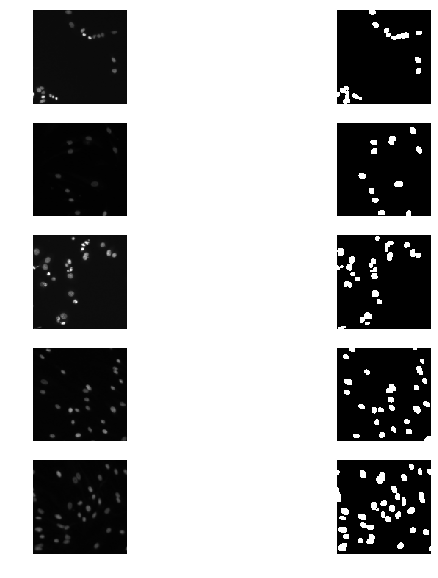

In [7]:
n_images = 5
fig, axes = plt.subplots(n_images,2,figsize=(10,10))
for i in range(n_images):
    ix = random.randint(0, len(train_ids))
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

### IoU (Intersection of the union)
The intersection of the union(IOU): Measure the total number of shared pixels after applying the masks

\begin{equation*}
  IOU = \frac{I_1 \cup I_2}{I_1 \cap I_2}
\end{equation*}

In [40]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [41]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## U-Net

![title](../../u-net-architecture.png)

In [42]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 128, 16) 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 

### Test Model with 100 images

In [43]:
limit = 100

checkpointer = ModelCheckpoint('model-unet-dsbowl2018-201905_100.h5', verbose=1, save_best_only=True)


results = model.fit(X_train[:limit], Y_train[:limit], validation_split=0.1, batch_size=5, epochs=40, 
                    callbacks=[checkpointer])

Train on 90 samples, validate on 10 samples
Epoch 1/40
90/90 [==============================] - 2s 22ms/step - loss: 0.5236 - my_iou_metric: 4.8431e-04 - val_loss: 0.4436 - val_my_iou_metric: 0.0986

Epoch 00001: val_loss improved from inf to 0.44364, saving model to model-unet-dsbowl2018-201905_100.h5
Epoch 2/40
90/90 [==============================] - 0s 3ms/step - loss: 0.3814 - my_iou_metric: 0.0479 - val_loss: 0.2806 - val_my_iou_metric: 0.0811

Epoch 00002: val_loss improved from 0.44364 to 0.28064, saving model to model-unet-dsbowl2018-201905_100.h5
Epoch 3/40
90/90 [==============================] - 0s 3ms/step - loss: 0.2636 - my_iou_metric: 0.0869 - val_loss: 0.2759 - val_my_iou_metric: 0.1455

Epoch 00003: val_loss improved from 0.28064 to 0.27589, saving model to model-unet-dsbowl2018-201905_100.h5
Epoch 4/40
90/90 [==============================] - 0s 3ms/step - loss: 0.2138 - my_iou_metric: 0.1450 - val_loss: 0.1803 - val_my_iou_metric: 0.2679

Epoch 00004: val_loss impro

90/90 [==============================] - 0s 3ms/step - loss: 0.0871 - my_iou_metric: 0.4850 - val_loss: 0.0878 - val_my_iou_metric: 0.5145

Epoch 00037: val_loss did not improve from 0.08725
Epoch 38/40
90/90 [==============================] - 0s 4ms/step - loss: 0.0841 - my_iou_metric: 0.4946 - val_loss: 0.0983 - val_my_iou_metric: 0.4745

Epoch 00038: val_loss did not improve from 0.08725
Epoch 39/40
90/90 [==============================] - 0s 3ms/step - loss: 0.0819 - my_iou_metric: 0.5102 - val_loss: 0.0874 - val_my_iou_metric: 0.5201

Epoch 00039: val_loss did not improve from 0.08725
Epoch 40/40
90/90 [==============================] - 0s 3ms/step - loss: 0.0798 - my_iou_metric: 0.5166 - val_loss: 0.0923 - val_my_iou_metric: 0.5082

Epoch 00040: val_loss did not improve from 0.08725


### Test Model with 200 images

In [12]:
limit = 200

checkpointer = ModelCheckpoint('model-unet-dsbowl2018-201905_200.h5', verbose=1, save_best_only=True)


results = model.fit(X_train[:limit], Y_train[:limit], validation_split=0.1, batch_size=5, epochs=40, 
                    callbacks=[checkpointer])

Train on 180 samples, validate on 20 samples
Epoch 1/40
180/180 [==============================] - 1s 3ms/step - loss: 0.0974 - my_iou_metric: 0.4698 - val_loss: 0.1513 - val_my_iou_metric: 0.4363

Epoch 00001: val_loss improved from inf to 0.15130, saving model to model-unet-dsbowl2018-201905_200.h5
Epoch 2/40
180/180 [==============================] - 1s 3ms/step - loss: 0.0977 - my_iou_metric: 0.4832 - val_loss: 0.0709 - val_my_iou_metric: 0.5259

Epoch 00002: val_loss improved from 0.15130 to 0.07090, saving model to model-unet-dsbowl2018-201905_200.h5
Epoch 3/40
180/180 [==============================] - 1s 3ms/step - loss: 0.0910 - my_iou_metric: 0.4876 - val_loss: 0.0740 - val_my_iou_metric: 0.5083

Epoch 00003: val_loss did not improve from 0.07090
Epoch 4/40
180/180 [==============================] - 1s 3ms/step - loss: 0.0897 - my_iou_metric: 0.5035 - val_loss: 0.0748 - val_my_iou_metric: 0.5031

Epoch 00004: val_loss did not improve from 0.07090
Epoch 5/40
180/180 [=========


Epoch 00039: val_loss did not improve from 0.06765
Epoch 40/40
180/180 [==============================] - 1s 3ms/step - loss: 0.0443 - my_iou_metric: 0.6834 - val_loss: 0.0815 - val_my_iou_metric: 0.5620

Epoch 00040: val_loss did not improve from 0.06765


### Test Model with 300 images

In [13]:
limit = 300

checkpointer = ModelCheckpoint('model-unet-dsbowl2018-201905_300.h5', verbose=1, save_best_only=True)


results = model.fit(X_train[:limit], Y_train[:limit], validation_split=0.1, batch_size=5, epochs=40, 
                    callbacks=[checkpointer])

Train on 270 samples, validate on 30 samples
Epoch 1/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0746 - my_iou_metric: 0.5695 - val_loss: 0.0793 - val_my_iou_metric: 0.5771

Epoch 00001: val_loss improved from inf to 0.07927, saving model to model-unet-dsbowl2018-201905_300.h5
Epoch 2/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0716 - my_iou_metric: 0.5704 - val_loss: 0.0774 - val_my_iou_metric: 0.6042

Epoch 00002: val_loss improved from 0.07927 to 0.07739, saving model to model-unet-dsbowl2018-201905_300.h5
Epoch 3/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0606 - my_iou_metric: 0.6041 - val_loss: 0.0778 - val_my_iou_metric: 0.6069

Epoch 00003: val_loss did not improve from 0.07739
Epoch 4/40
270/270 [==============================] - 1s 3ms/step - loss: 0.0585 - my_iou_metric: 0.6203 - val_loss: 0.0761 - val_my_iou_metric: 0.6039

Epoch 00004: val_loss improved from 0.07739 to 0.07615, saving model to model-un

270/270 [==============================] - 1s 3ms/step - loss: 0.0326 - my_iou_metric: 0.7558 - val_loss: 0.0926 - val_my_iou_metric: 0.5967

Epoch 00040: val_loss did not improve from 0.07615


## Predictions

In [16]:
# Predict on train, val and test
#model = load_model('model-unet-dsbowl2018-201905_100.h5', custom_objects={'mean_iou': mean_iou})
model = load_model('model-unet-dsbowl2018-201905_100.h5', custom_objects={'my_iou_metric': my_iou_metric})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 1ms/step


### IMAGE |  MASK | PREDICTION

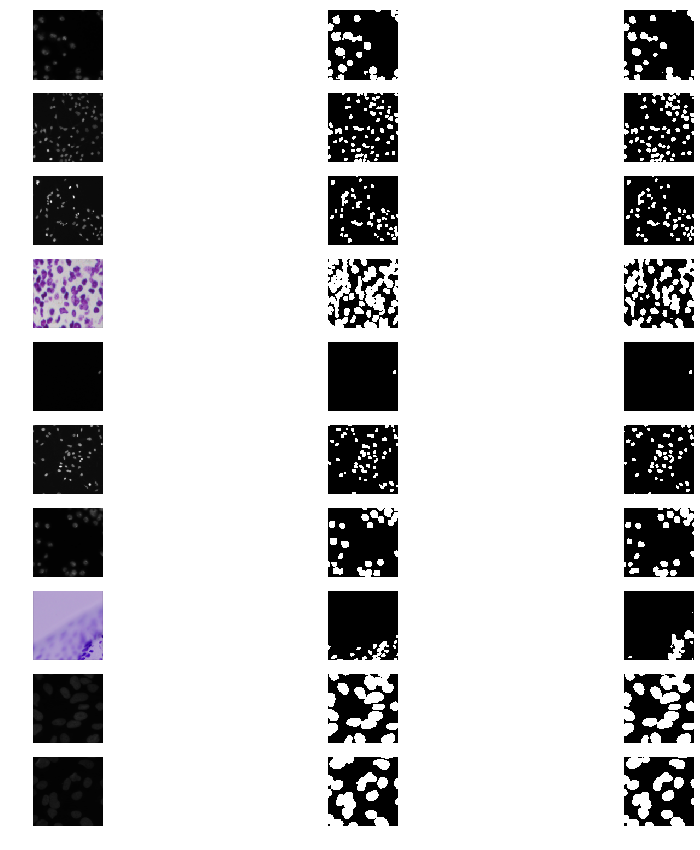

In [17]:
n_images = 10

fig, axes = plt.subplots(n_images,3,figsize=(15,15))

for i in range(n_images):
    ix = random.randint(0, len(preds_train_t-1))
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
    axes[i,2].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

In [36]:

y_true_in = Y_train[10]
y_pred_in = preds_train_t[10]

labels = label(y_true_in > 0.5)
y_pred = label(y_pred_in > 0.5)

true_objects = len(np.unique(labels))
pred_objects = len(np.unique(y_pred))

print(true_objects)
print(pred_objects)

intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]
print(intersection)

31
26
[[1.25e+04 1.10e+01 0.00e+00 7.50e+01 3.00e+00 4.10e+01 7.00e+00 1.40e+01
  1.50e+01 3.00e+01 2.10e+01 9.00e+00 3.90e+01 3.20e+01 3.30e+01 1.60e+01
  2.30e+01 2.00e+00 1.50e+01 5.00e+00 0.00e+00 1.00e+01 1.00e+01 1.00e+00
  4.00e+00 1.20e+01]
 [1.50e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [2.20e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 5.80e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [2.40e+01 0.00e+00 9.

In [37]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value